### Set up a Latin hypercube of HOD parameters

In [1]:
import os
import tempfile

from acm.hod import HODLatinHypercube
from sunbird.inference.priors import Yuan23

# infer parameter ranges from the priors adopted in arXiv:2203.11963
ranges = Yuan23().ranges

# sample and distribute on a Latin hypercube
lhc = HODLatinHypercube(ranges)
lhc.sample(n=4)
print(lhc.params)

# split parameters across different cosmologies if needed
cosmos = [0, 1]
lhc_split = lhc.split_by_cosmo(cosmos=cosmos)
    
# optionally save to a csv file when calling the methods
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.csv')
    lhc.sample(n=4, save_fn=fn)

    fns = [os.path.join(tmp_dir, f'tmp_c{cosmo}.csv') for cosmo in range(len(cosmos))]
    lhc.split_by_cosmo(cosmos=cosmos, save_fn=fns)

2025-01-17 16:12:42.606521: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


{'logM_cut': [12.567813185433211, 13.2068404639758, 13.46648495087787, 13.061023548399358], 'logM_1': [13.81042058509298, 14.79146439502344, 14.277010484555511, 14.546610652665274], 'sigma': [-2.8503654459124905, -0.4653715213419898, -1.4758869911804464, 0.7359270178122519], 'alpha': [0.38927643142748763, 1.1179645770734907, 0.8770778890927675, 1.2824048715686593], 'kappa': [0.22419110639780673, 0.6052402652135809, 0.4568133507132819, 0.8818049000790982], 'alpha_c': [0.30871759137539473, 0.14276786844411327, 0.5058350346305257, 0.17801657510117977], 'alpha_s': [0.8618407177971947, 0.6192139083716875, 1.0930666095309716, 1.3306896892944882], 's': [-0.8741018311120922, 0.6873261224345779, -0.46891731755493393, 0.3503785125158896], 'A_cen': [0.868505456315738, -0.3938821152409795, -0.666396171906313, 0.05051529533030341], 'A_sat': [-0.7251929689477836, -0.17726298406493424, 0.31477014698256545, 0.597617821251599], 'B_cen': [-0.5331485702705865, -0.011126820305891516, -0.33712838895248826,

### Sample HODs on a cubic box, powered by AbacusHOD
Note: This is memory intensive. Only run on a dedicated node.

In [2]:
from acm.hod import BoxHOD
from acm.utils import setup_logging

setup_logging()

# pick one set of HOD parameters from the LHC
hod_params = lhc.params['c000']
hod_params = {key: hod_params[key][0] for key in hod_params.keys()}

# load HOD class
abacus = BoxHOD(varied_params=hod_params.keys(),
                sim_type='base', redshift=0.5,
                cosmo_idx=0, phase_idx=0)

# populate dark matter halos
hod_catalog = abacus.run(hod_params, nthreads=16, add_rsd=True, tracer_density_mean=5e-4)['LRG']

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/conda/lib/python3.10/site-packages/asdf/entry_points.py:46: AsdfWarning: asdf.extensions plugin from package asdf-astropy==0.6.1 failed to load:

KeyError: 'Resource unavailable for URI: asdf://asdf-format.org/transform/manifests/transform-1.6.0'
  warnings.warn(


Loading simulation by slab,  0
Loading simulation by slab,  1
Loading simulation by slab,  2
Loading simulation by slab,  3
Loading simulation by slab,  4
Loading simulation by slab,  5
Loading simulation by slab,  6
Loading simulation by slab,  7
Loading simulation by slab,  8
Loading simulation by slab,  9
Loading simulation by slab,  10
Loading simulation by slab,  11
Loading simulation by slab,  12
Loading simulation by slab,  13
Loading simulation by slab,  14
Loading simulation by slab,  15
Loading simulation by slab,  16
Loading simulation by slab,  17
Loading simulation by slab,  18
Loading simulation by slab,  19
Loading simulation by slab,  20
Loading simulation by slab,  21
Loading simulation by slab,  22
Loading simulation by slab,  23
Loading simulation by slab,  24
Loading simulation by slab,  25
Loading simulation by slab,  26
Loading simulation by slab,  27
Loading simulation by slab,  28
Loading simulation by slab,  29
Loading simulation by slab,  30
Loading simulation

### Calculate the two-point clustering

[000128.81]  01-17 16:15  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000128.81]  01-17 16:15  TwoPointCorrelationFunction  INFO     Running auto-correlation.
[000128.81]  01-17 16:15  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000135.40]  01-17 16:15  TwoPointCorrelationFunction  INFO     Analytically computing two-point counts R1R2.
[000135.40]  01-17 16:15  TwoPointCorrelationFunction  INFO     Correlation function computed in elapsed time 6.59 s.


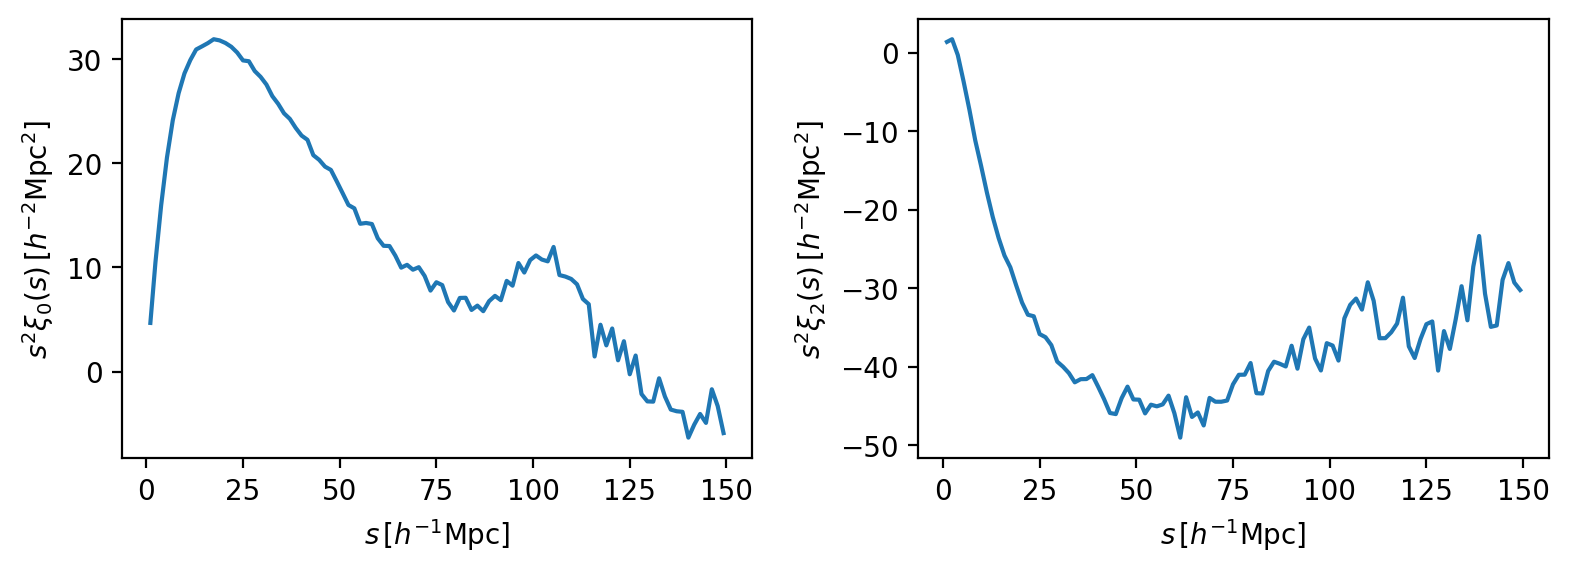

In [4]:
from pycorr import TwoPointCorrelationFunction
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

positions = np.c_[hod_catalog['X'], hod_catalog['Y'], hod_catalog['Z_RSD']]

sedges = np.linspace(0, 150, 100)
muedges = np.linspace(-1, 1, 241)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

result = TwoPointCorrelationFunction(data_positions1=positions, boxsize=abacus.boxsize,
                                     mode='smu', edges=(sedges, muedges), los='z',
                                     nthreads=16, position_type='pos')
s, multipoles = result(ells=(0, 2, 4), return_sep=True)
ax[0].plot(s, s**2*multipoles[0])
ax[1].plot(s, s**2*multipoles[1])
    
ax[0].set_xlabel(r'$s\, [h^{-1}{\rm Mpc}]$')
ax[1].set_xlabel(r'$s\, [h^{-1}{\rm Mpc}]$')
ax[0].set_ylabel(r'$s^2 \xi_0(s)\,[h^{-2}{\rm Mpc^2}]$')
ax[1].set_ylabel(r'$s^2 \xi_2(s)\,[h^{-2}{\rm Mpc^2}]$')
plt.tight_layout()
plt.show()

### Populate cutsky mocks with a DESI geometry
Note: This is memory intensive. Only run on a dedicated node.

In [5]:
from acm.hod import CutskyHOD

# let's build our mock from two simulation snapshots at z = 0.5 and z = 0.8,
# which will cover two separate portions of our desired redshift range
snapshots = [0.5, 0.8]
zranges = [(0.41, 0.6), (0.6, 1.09)]

# load abacusHOD class
abacus = CutskyHOD(varied_params=hod_params.keys(),
                   zranges=zranges, snapshots=snapshots,
                   cosmo_idx=0, phase_idx=0)

# generate data and randoms (in sky coordinates)
data, randoms = abacus.run(hod_params, nthreads=128, generate_randoms=True, alpha_randoms=3)

Loading simulation by slab,  0
Loading simulation by slab,  1
Loading simulation by slab,  2
Loading simulation by slab,  3
Loading simulation by slab,  4
Loading simulation by slab,  5
Loading simulation by slab,  6
Loading simulation by slab,  7
Loading simulation by slab,  8
Loading simulation by slab,  9
Loading simulation by slab,  10
Loading simulation by slab,  11
Loading simulation by slab,  12
Loading simulation by slab,  13
Loading simulation by slab,  14
Loading simulation by slab,  15
Loading simulation by slab,  16
Loading simulation by slab,  17
Loading simulation by slab,  18
Loading simulation by slab,  19
Loading simulation by slab,  20
Loading simulation by slab,  21
Loading simulation by slab,  22
Loading simulation by slab,  23
Loading simulation by slab,  24
Loading simulation by slab,  25
Loading simulation by slab,  26
Loading simulation by slab,  27
Loading simulation by slab,  28
Loading simulation by slab,  29
Loading simulation by slab,  30
Loading simulation

Plotting footprint.


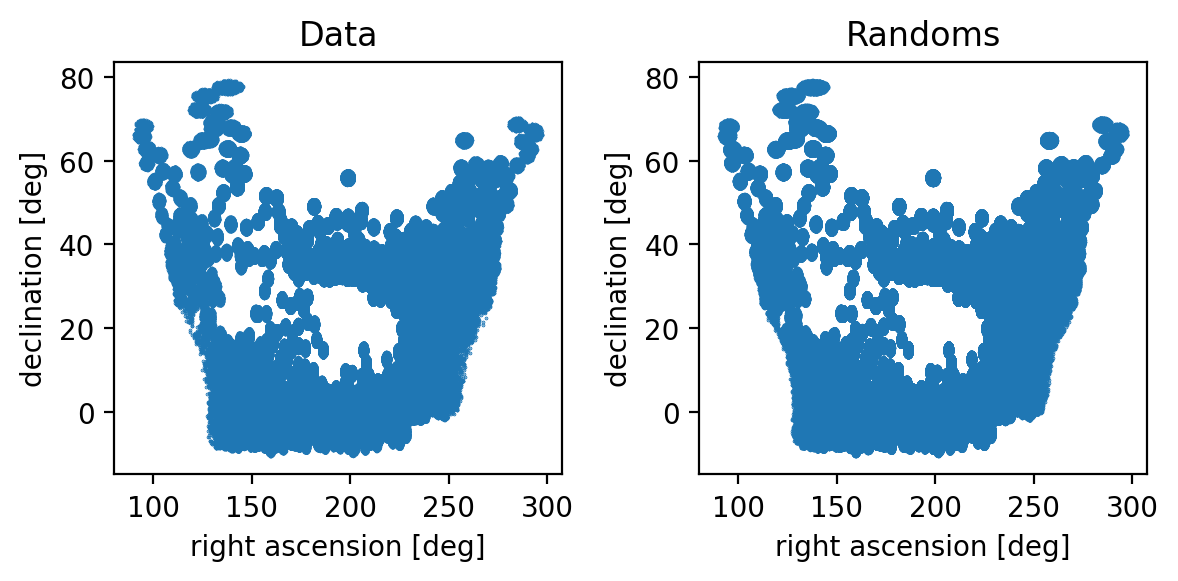

Plotting redshift distribution.


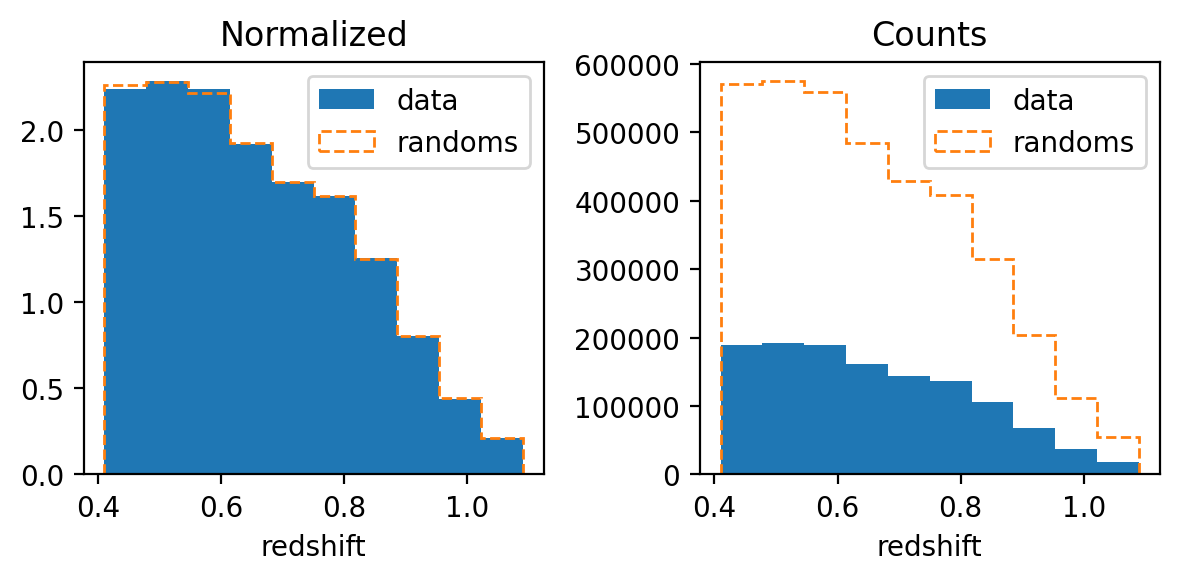

In [6]:
def plot_footprint():
    import matplotlib.pyplot as plt
    print('Plotting footprint.')
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].scatter(data['RA'], data['DEC'], s=0.1)
    ax[1].scatter(randoms['RA'], randoms['DEC'], s=0.1)
    ax[0].set_title('Data')
    ax[1].set_title('Randoms')
    for aa in ax:
        aa.set_xlabel('right ascension [deg]')
        aa.set_ylabel('declination [deg]')
    plt.tight_layout()
    plt.show()

def plot_redshift_distribution():
    import matplotlib.pyplot as plt
    print('Plotting redshift distribution.')
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].hist(data['Z'], density=True, label='data')
    ax[0].hist(randoms['Z'], density=True, label='randoms', ls='--', histtype='step')
    ax[1].hist(data['Z'], density=False, label='data')
    ax[1].hist(randoms['Z'], density=False, label='randoms', ls='--', histtype='step')
    ax[0].set_title('Normalized')
    ax[1].set_title('Counts')
    for aa in ax:
        aa.set_xlabel('redshift')
        aa.legend()
    plt.tight_layout()
    plt.show()


plot_footprint()
plot_redshift_distribution()

In [19]:
hod = {key: hod_params[key][466] for key in hod_params.keys()}

hod_dict, randoms_dict = abacus.run(hod, nthreads=16, full_sky=True, make_randoms=True, apply_nz=True, alpha_rand=5)

gen mocks 0.03718066215515137
gen mocks 0.0320744514465332
gen mocks 0.03724193572998047
gen mocks 0.052364349365234375
gen mocks 0.05679011344909668
[000048.61]  07-23 17:51  LightconeHOD                 INFO     Applying redshift cut: 0.4 < z < 0.6.
[000048.71]  07-23 17:51  LightconeHOD                 INFO     Raw data nbar: 0.0006247304346341545
[000048.71]  07-23 17:51  LightconeHOD                 INFO     Applying radial mask from /global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v1.5/LRG_NGC_nz.txt.
[000050.43]  07-23 17:51  LightconeHOD                 INFO     Downsampled data nbar: 0.0005199265044782844
[000050.43]  07-23 17:51  LightconeHOD                 INFO     Generating random catalog.
[000078.73]  07-23 17:52  LightconeHOD                 INFO     Applying radial mask from /global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v1.5/LRG_NGC_nz.txt.


In [20]:
alpha = len(randoms_dict['LRG']['RA'])/len(hod_dict['LRG']['RA'])
print(alpha)

4.417798634162719


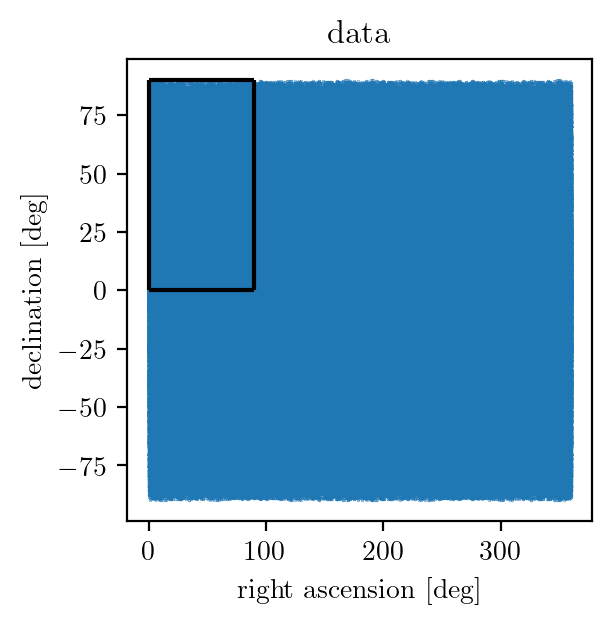

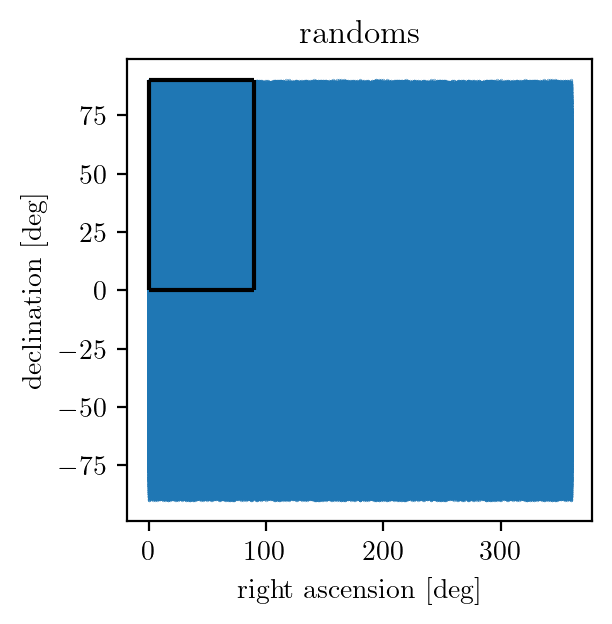

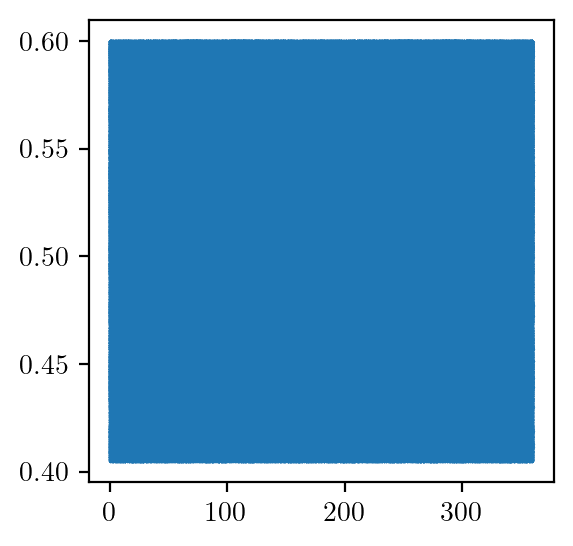

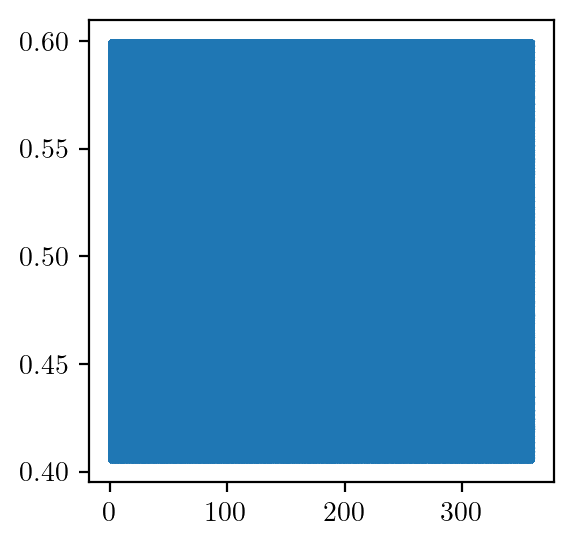

0.0 359.9997660628104


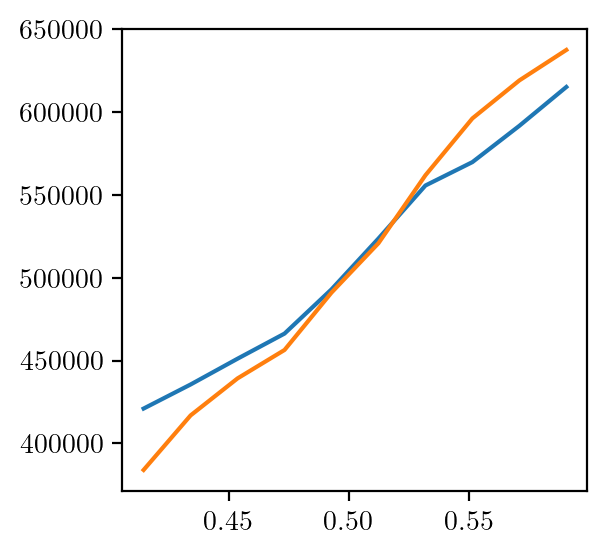

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(hod_dict['LRG']['RA'], hod_dict['LRG']['DEC'], marker='.', s=0.1)
ax.vlines(90, 0, 90, color='k')
ax.vlines(0, 0, 90, color='k')
ax.hlines(90, 0, 90, color='k')
ax.hlines(0, 0, 90, color='k')
ax.set_xlabel(r'\textrm{right ascension [deg]}')
ax.set_ylabel(r'\textrm{declination [deg]}')
ax.set_title('data')
plt.show()

fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(randoms_dict['LRG']['RA'], randoms_dict['LRG']['DEC'], marker='.', s=0.1)
ax.vlines(90, 0, 90, color='k')
ax.vlines(0, 0, 90, color='k')
ax.hlines(90, 0, 90, color='k')
ax.hlines(0, 0, 90, color='k')
ax.set_xlabel(r'\textrm{right ascension [deg]}')
ax.set_ylabel(r'\textrm{declination [deg]}')
ax.set_title('randoms')
# ax.set_xlim(0, 92)
# ax.set_ylim(0, 92)
plt.show()

fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(hod_dict['LRG']['RA'], hod_dict['LRG']['Z'], marker='.', s=0.1)
plt.show()

fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(randoms_dict['LRG']['RA'], randoms_dict['LRG']['Z'], marker='.', s=0.1)
plt.show()

print(hod_dict['LRG']['RA'].min(), hod_dict['LRG']['RA'].max())
# print(hod_dict['LRG']['Z'].min(), hod_dict['LRG']['Z'].max())

fig, ax = plt.subplots(figsize=(3, 3))
hist, bin_edges = np.histogram(hod_dict['LRG']['Z'])
bin_centres = (bin_edges[1:] + bin_edges[:-1]) / 2
ax.plot(bin_centres, hist)

hist, bin_edges = np.histogram(randoms_dict['LRG']['Z'])
bin_centres = (bin_edges[1:] + bin_edges[:-1]) / 2
ax.plot(bin_centres, hist / alpha)
plt.show()

# ax.hist(randoms_dict['LRG']['Z'], alpha=0.5)
# plt.show()

# fig, ax = plt.subplots(figsize=(3, 3))
# ax.scatter(hod_dict['LRG']['y'], hod_dict['LRG']['z'], marker='.', s=0.1)
# plt.show()

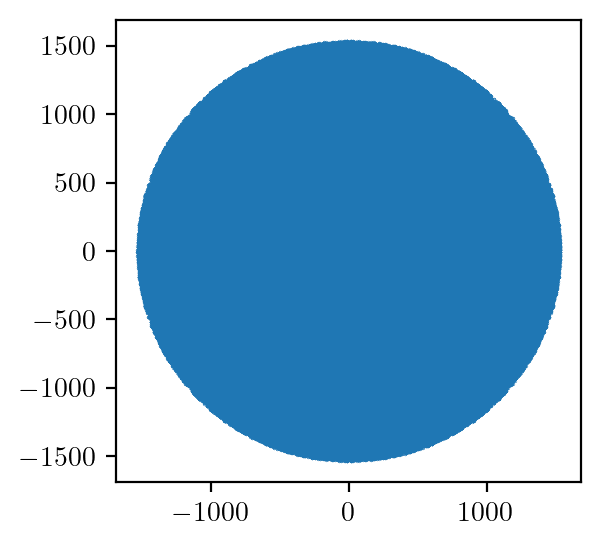

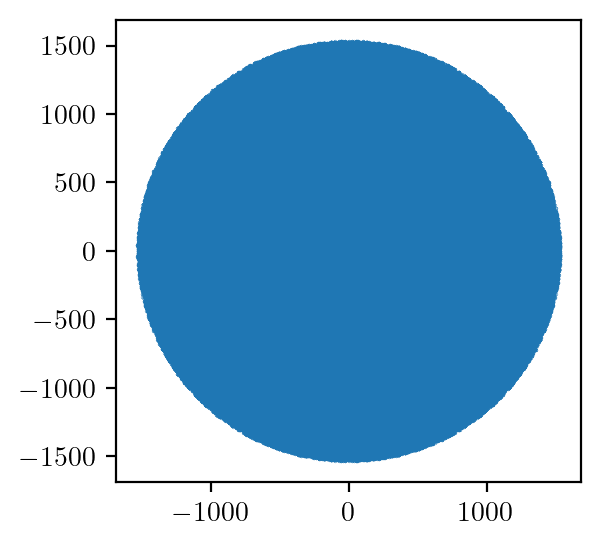

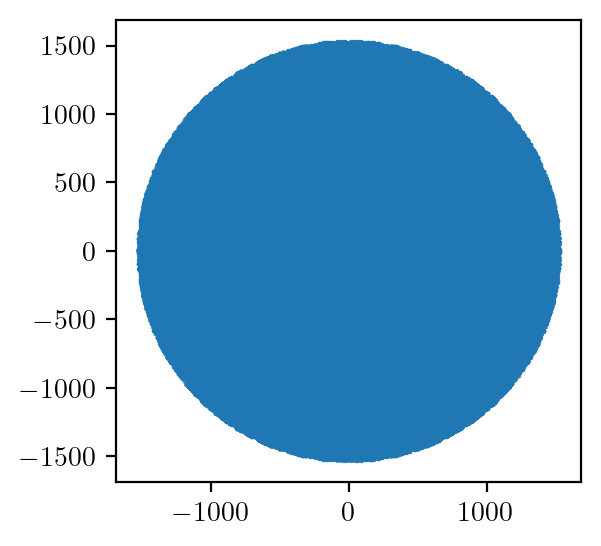

-1534.2169025448388 1534.2169025448388
-1534.5162717883925 1534.5162717883925
-1533.6951536502147 1533.6951536502147


In [8]:
from cosmoprimo.fiducial import AbacusSummit
from mockfactory import sky_to_cartesian
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


cosmo = AbacusSummit()
data_dist = cosmo.comoving_radial_distance(hod_dict['LRG']['Z'])
data_positions = sky_to_cartesian(dist=data_dist,
                                  ra=hod_dict['LRG']['RA'],
                                  dec=hod_dict['LRG']['DEC'])


fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(data_positions[:, 0], data_positions[:, 1], marker='.', s=0.1)
# ax.scatter(np.concatenate([hod_dict['LRG']['X'], -hod_dict['LRG']['X']]), np.concatenate([hod_dict['LRG']['Y'], -hod_dict['LRG']['Y']]), marker='.', s=0.1)
plt.show()

fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(data_positions[:, 0], data_positions[:, 2], marker='.', s=0.1)
plt.show()

fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(data_positions[:, 1], data_positions[:, 2], marker='.', s=0.1)
plt.show()

print(data_positions[:, 0].min(), data_positions[:, 0].max())
print(data_positions[:, 1].min(), data_positions[:, 1].max())
print(data_positions[:, 2].min(), data_positions[:, 2].max())

In [22]:
from mockfactory.desi import is_in_desi_footprint

data_mask = is_in_desi_footprint(
    ra=hod_dict['LRG']['RA'],
    dec=hod_dict['LRG']['DEC'],
    release='y1'
)

randoms_mask = is_in_desi_footprint(
    ra=randoms_dict['LRG']['RA'],
    dec=randoms_dict['LRG']['DEC'],
    release='y1'
)

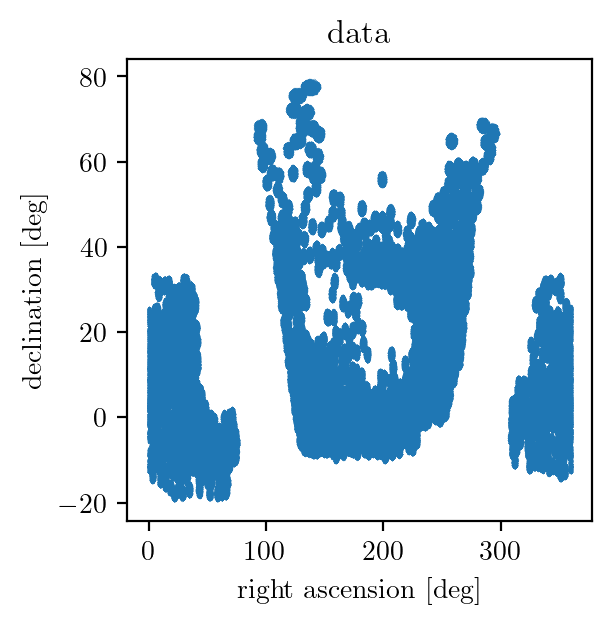

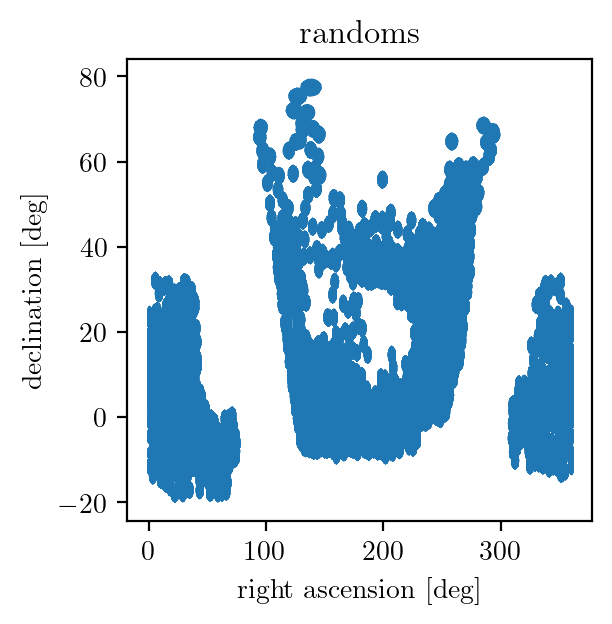

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(hod_dict['LRG']['RA'][data_mask], hod_dict['LRG']['DEC'][data_mask], marker='.', s=0.1)
ax.set_xlabel(r'\textrm{right ascension [deg]}')
ax.set_ylabel(r'\textrm{declination [deg]}')
# ax.set_xlim(0, 92)
ax.set_title('data')
plt.show()

fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(randoms_dict['LRG']['RA'][randoms_mask], randoms_dict['LRG']['DEC'][randoms_mask], marker='.', s=0.1)
ax.set_xlabel(r'\textrm{right ascension [deg]}')
ax.set_ylabel(r'\textrm{declination [deg]}')
# ax.set_xlim(0, 92)
ax.set_title('randoms')
plt.show()

ndata = len(hod_dict['LRG']['RA'][data_mask])

In [24]:
from mockfactory.utils import sky_to_cartesian
from cosmoprimo.fiducial import AbacusSummit
from pycorr import TwoPointCorrelationFunction, setup_logging
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

setup_logging()

sedges = np.linspace(0, 150, 100)
muedges = np.linspace(-1, 1, 241)

cosmo = AbacusSummit(0)

data_dist = cosmo.comoving_radial_distance(hod_dict['LRG']['Z'])
data_positions = sky_to_cartesian(dist=data_dist[data_mask],
                                  ra=hod_dict['LRG']['RA'][data_mask],
                                  dec=hod_dict['LRG']['DEC'][data_mask])

randoms_dist = cosmo.comoving_radial_distance(randoms_dict['LRG']['Z'])
randoms_positions = sky_to_cartesian(dist=randoms_dist[randoms_mask],
                                     ra=randoms_dict['LRG']['RA'][randoms_mask],
                                     dec=randoms_dict['LRG']['DEC'][randoms_mask])

result = TwoPointCorrelationFunction(data_positions1=data_positions, randoms_positions1=randoms_positions,
                                     mode='smu', edges=(sedges, muedges), los='midpoint', estimator='landyszalay',
                                     nthreads=128, position_type='pos')

[000005.65]  07-23 17:54  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000005.65]  07-23 17:54  TwoPointCorrelationFunction  INFO     Running auto-correlation.
[000005.65]  07-23 17:54  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000006.22]  07-23 17:54  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000009.82]  07-23 17:54  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
[000017.86]  07-23 17:54  TwoPointCorrelationFunction  INFO     Correlation function computed in elapsed time 12.21 s.


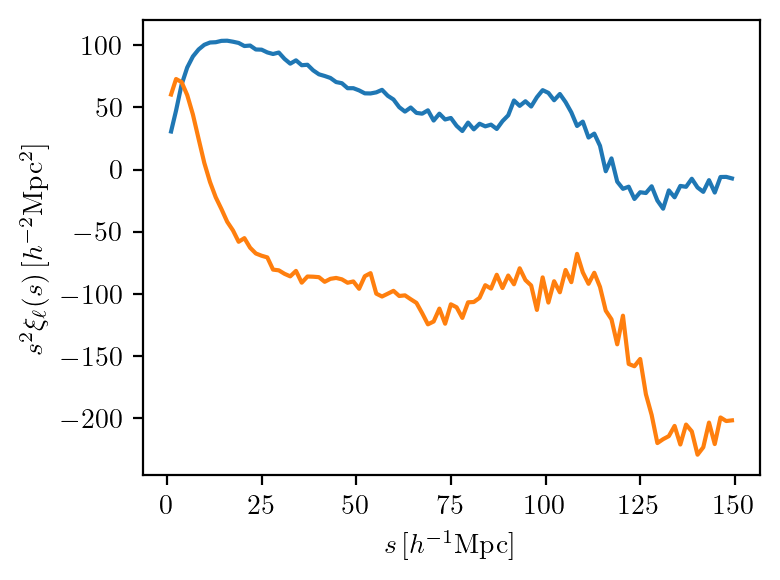

In [25]:
s, multipoles = result(ells=(0, 2), return_sep=True)
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(s, s**2 * multipoles[0])
ax.plot(s, s**2 * multipoles[1])
ax.set_xlabel(r'$s\, [h^{-1}{\rm Mpc}]$')
ax.set_ylabel(r'$s^2 \xi_\ell(s)\,[h^{-2}{\rm Mpc^2}]$')
plt.tight_layout()
plt.show()
plt.show()

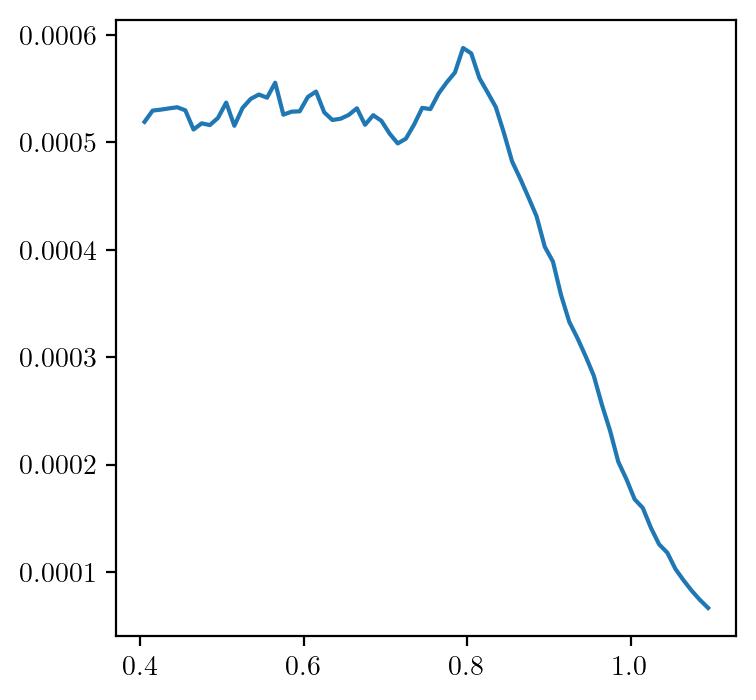

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


nz_fn = '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v1.5/LRG_NGC_nz.txt'
data = np.genfromtxt(nz_fn, skip_header=3)

fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(data[:, 0], data[:, 3])
plt.show()

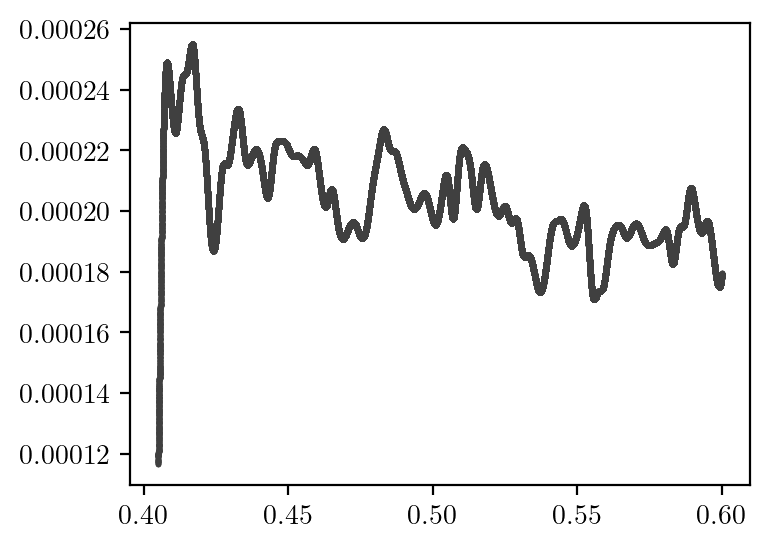

In [4]:
import numpy as np
from cosmoprimo.fiducial import AbacusSummit
import healpy as hp
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')



def spl_nofz(zarray, fsky, cosmo, zmin, zmax, Nzbins=100):
    zbins = np.linspace(zmin, zmax, Nzbins+1)
    Nz, zbins = np.histogram(zarray, zbins)

    zmid = zbins[0:-1] + (zmax-zmin)/Nzbins/2.0
    # set z range boundaries to be zmin and zmax and avoid the interpolation error
    zmid[0], zmid[-1] = zbins[0], zbins[-1]

    rmin = cosmo.comoving_radial_distance(zbins[0:-1])
    rmax = cosmo.comoving_radial_distance(zbins[1:])

    vol = fsky * 4./3*np.pi * (rmax**3.0 - rmin**3.0)
    nz_array = Nz/vol
    spl_nz = InterpolatedUnivariateSpline(zmid, nz_array)
    return spl_nz

def sky_fraction(randoms_fn):
    """Compute the sky fraction of a randoms catalogue."""
    data = np.genfromtxt(randoms_fn)
    ra = data[:, 0]
    dec = data[:, 1]
    nside = 512
    npix = hp.nside2npix(nside)
    phi = np.radians(ra)
    theta = np.radians(90.0 - dec)
    pixel_indices = hp.ang2pix(nside, theta, phi)
    pixel_unique, counts = np.unique(pixel_indices, return_counts=True)
    fsky = len(pixel_unique)/npix
    return fsky

fsky = 0.125
cosmo = AbacusSummit(0)
zmin, zmax = 0.4, 0.6

z = hod_dict['LRG']['Z']

fig, ax = plt.subplots(figsize=(4, 3))
nz = spl_nofz(z, fsky, cosmo, zmin, zmax)
ax.scatter(z, nz(z), s=1.0, c='#404040',)
plt.show()